# **CSAI ASSIGNMENT 1**
# Srujana Vanka - 2020102005

## objective 1

In [ ]:
# Import libraries
!pip install nilearn 
import nilearn
from nilearn import datasets                          # Fetch data using nilearn dataset fetcher
from nilearn import image
from nilearn.decoding import Decoder
import matplotlib                                     # Matplotlib to plot the outputs 
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
from nilearn.decoding import Decoder
from nilearn.maskers import NiftiMasker                # Load nilearn NiftiMasker
from nilearn.image import index_img              
from sklearn.model_selection import LeaveOneGroupOut   # Data splitting object for cross validation
import warnings                                        # Ignore warnings in output
warnings.simplefilter("ignore") 

In [8]:
# Fetches the Haxby dataset, which is a collection of neuroimaging data, and provides 
# information about the different pieces of data that are included in the dataset
haxby_dataset = datasets.fetch_haxby()

# Get list of keys in the dataset and sort them
keys = sorted(list(haxby_dataset.keys()))
print("List of keys in the dataset (sorted order): ", keys)

# First functional Nifti image
func_filename = haxby_dataset["func"][0]

# GFirst anatomical Nifti image
anat_filename = haxby_dataset["anat"][0]

print("Anatomical Nifti image (3D) present at (First subject): ", anat_filename)
print("Functional Nifti image (4D) present at (First subject): ", func_filename)

# Printing the shape of loaded functional image gives you the total number of brain volumes
fmri_img = image.load_img(haxby_dataset['func'])
print("Shape of the loaded functional image: ", fmri_img.shape)
     

List of keys in the dataset (sorted order):  ['anat', 'description', 'func', 'mask', 'mask_face', 'mask_face_little', 'mask_house', 'mask_house_little', 'mask_vt', 'session_target']
Anatomical Nifti image (3D) present at (First subject):  /root/nilearn_data/haxby2001/subj2/anat.nii.gz
Functional Nifti image (4D) present at (First subject):  /root/nilearn_data/haxby2001/subj2/bold.nii.gz
Shape of the loaded functional image:  (40, 64, 64, 1452)


In [9]:
# Reading labels from a file specified in haxby_dataset.session_target[0] and storing them in a pandas DataFrame labels
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

# Extract stimuli information
stimuli = labels['labels']
categories = stimuli[stimuli != 'rest'].unique()
session_labels = labels.loc[stimuli != 'rest', "chunks"]

# task_mask is applied to the fMRI data stored in func_filename
task_mask = (stimuli != 'rest')
task_data = index_img(func_filename, task_mask)

# Splitting object for cross validation
cv = LeaveOneGroupOut()

In [26]:
def get_masker(mask_filename):
    """Return a NiftiMasker object for the specified mask file."""
    return NiftiMasker(mask_img=mask_filename, standardize=True)

def get_decoder(masker, task_data, classification_target, session_labels, cv, scoring='roc_auc'):
    """Return a fitted decoder object."""
    decoder = Decoder(estimator='svc_l1', cv=cv,
                      mask=masker, scoring=scoring)
    decoder.fit(task_data, classification_target, groups=session_labels)
    return decoder

def init_decoder(masker, task_data, classification_target, session_labels, cv, scoring='roc_auc'):
    """Return a fitted dummy decoder object."""
    decoder = Decoder(estimator='dummy_classifier', cv=cv,
                      mask=masker, scoring=scoring)
    decoder.fit(task_data, classification_target, groups=session_labels)
    return decoder

mask_names = ['mask_vt', 'mask_face', 'mask_house']
mask_scores = {}
mask_chance_scores = {}

for m in mask_names:
    # print("Working on %s" % m)
    mask_filename = haxby_dataset[m][0]
    masker = get_masker(mask_filename)
    mask_scores[m] = {}
    mask_chance_scores[m] = {}

    for category in categories:
        # print("Processing %s %s" % (m, category))
        classification_target = (stimuli[task_mask] == category)
        decoder = get_decoder(masker, task_data, classification_target, session_labels, cv)
        mask_scores[m][category] = decoder.cv_scores_[1]
        # print("Scores: %1.2f +- %1.2f" % (
              # np.mean(mask_scores[m][category]),
              # np.std(mask_scores[m][category])))

        dummy_decoder = init_decoder(masker, task_data, classification_target, session_labels, cv)
        mask_chance_scores[m][category] = dummy_decoder.cv_scores_[1]

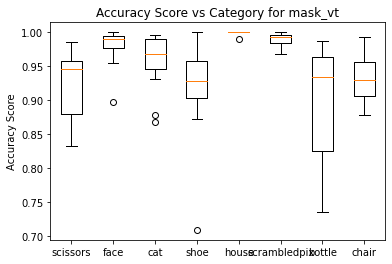

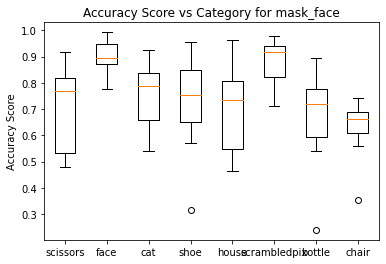

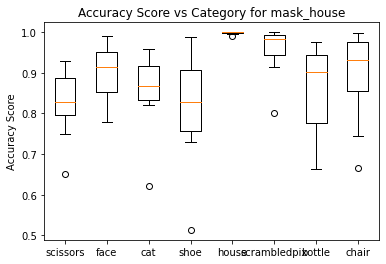

In [24]:
mask_names = ['mask_vt', 'mask_face', 'mask_house']

def plot_mask(mask_names, mask_scores, categories):
    for m in mask_names:
        fig = plot.figure(figsize=(8,8))
        fig, ax = plot.subplots()
        ax.boxplot([mask_scores[m][cat] for cat in categories], labels=categories)
        ax.set_title("Accuracy Score vs Category for %s" % m)
        ax.set_ylabel("Accuracy Score")
    plot.show()

plot_mask(mask_names, mask_scores, categories)

## objective 2

In [ ]:
# Import libraries
!pip install nilearn 
import nilearn
from nilearn import datasets                          # Fetch data using nilearn dataset fetcher
from nilearn import image
from nilearn.decoding import Decoder
from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import index_img           
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [11]:
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=' ')

conditions = behavioral['labels']
sessions = behavioral['chunks']

# a binary array indicating which events belong to which session
unique_sessions = sessions.unique()

In [12]:
TR = 2.5
# a dictionary that maps each session to a list of event information
events = {}

for session in np.unique(sessions):
    conditions_session = conditions[sessions == session]
    n_scans = len(conditions_session)
    frame_times = TR * np.arange(n_scans)
    duration = TR * np.ones(n_scans)
    
    events[session] = pd.DataFrame({
        'onset': frame_times,
        'trial_type': conditions_session,
        'duration': duration
    })

assert len(events) == len(np.unique(sessions))

for i in events:
    assert events[i].shape == (121, 3)

# Three ingredients that should be user specified in order 
# to make a design matrix through stimulus onset, stimlus
# conditions and duration.
print(events)

print(conditions.shape)
print(conditions_session.shape)

{0:      onset trial_type  duration
0      0.0       rest       2.5
1      2.5       rest       2.5
2      5.0       rest       2.5
3      7.5       rest       2.5
4     10.0       rest       2.5
..     ...        ...       ...
116  290.0       rest       2.5
117  292.5       rest       2.5
118  295.0       rest       2.5
119  297.5       rest       2.5
120  300.0       rest       2.5

[121 rows x 3 columns], 1:      onset trial_type  duration
121    0.0       rest       2.5
122    2.5       rest       2.5
123    5.0       rest       2.5
124    7.5       rest       2.5
125   10.0       rest       2.5
..     ...        ...       ...
237  290.0       rest       2.5
238  292.5       rest       2.5
239  295.0       rest       2.5
240  297.5       rest       2.5
241  300.0       rest       2.5

[121 rows x 3 columns], 2:      onset trial_type  duration
242    0.0       rest       2.5
243    2.5       rest       2.5
244    5.0       rest       2.5
245    7.5       rest       2.5
246   10.0  

In [13]:
contrasts = {
    'bottle': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'cat':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'chair':   array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'face':   array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'house':   array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'rest':   array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'scissors':   array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
    'scrambledpix':   array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
    'shoe':   array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
}

def compute_z_maps(fmri_img, TR, events, sessions, categories, haxby_dataset):
    z_maps = []
    conditions_label = []
    each_session_label = []

    for session in np.unique(sessions):
        glm = FirstLevelModel(t_r=TR,
                              mask_img=haxby_dataset.mask,
                              high_pass=0.008,
                              smoothing_fwhm=8.)  

        # Fit the GLM to the fMRI data and events for this session
        fmri_session = index_img(fmri_img, sessions == session)
        glm.fit(fmri_session, events=events[session])
        # Computing the contrast map by subtracting the z-score map of 'rest' condition from the z-score map of the condition
        for condition in categories:
            condition_minus_rest = contrasts[condition] - contrasts['rest']
            z_map_condition_vs_rest = glm.compute_contrast(condition_minus_rest,
                                             output_type='z_score')
            z_maps.append(z_map_condition_vs_rest)
            conditions_label.append(condition)
            each_session_label.append(session)
    return z_maps, conditions_label, each_session_label


glm = FirstLevelModel(t_r=TR,
                      mask_img=haxby_dataset.mask,
                      high_pass=0.008,
                      smoothing_fwhm=8.)


fmri_img = image.load_img(haxby_dataset['func'])
z_maps, conditions_label, each_session_label = compute_z_maps(fmri_img, TR, events, sessions, categories, haxby_dataset)

In [25]:
mask_scores = {}
mask_scores_face_house = {}

assert len(z_maps) == 96 # z_maps must have 96 elements
assert len(conditions_label) == 96 # conditions_label must have 96 elements
assert len(each_session_label) == 96 # each_session_label must have 96 elements

for mask_name in mask_names:
    mask_filename = haxby_dataset[mask_name][0]
    masker = NiftiMasker(mask_img=mask_filename, standardize=True)
    mask_scores_face_house[mask_name] = {}
    
    for category in categories:
        classification_target = conditions_label
        decoder = Decoder(estimator='svc_l1', cv=cv,
                          mask=masker, scoring='roc_auc')
        decoder.fit(z_maps, classification_target, groups=each_session_label)
        mask_scores_face_house[mask_name][category] = decoder.cv_scores_[category]
        mask_scores[mask_name + "_" + category] = decoder.cv_scores_[category]

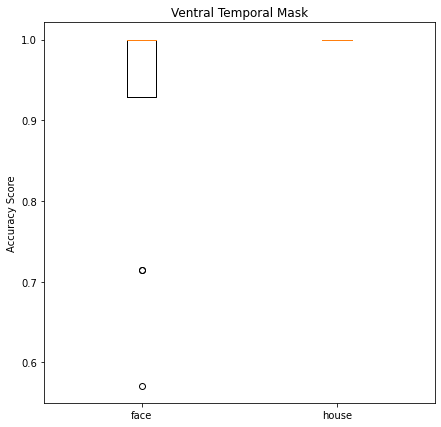

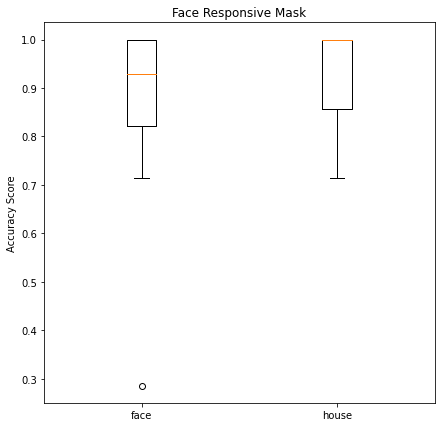

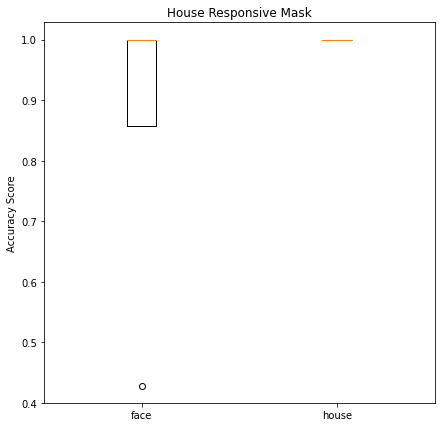

In [30]:
graph_titles = ['Ventral Temporal Mask', 'Face Responsive Mask', 'House Responsive Mask']

for i, mask_name in enumerate(mask_names):
    fig, ax = plot.subplots(figsize=(7, 7))
    categories = ['face', 'house']
    ax.boxplot([mask_scores_face_house[mask_name][cat] for cat in categories], labels=categories)
    ax.set_title(graph_titles[i])
    ax.set_ylabel("Accuracy Score")
    plot.show()

**1. What are the differences between 1 and 2 in terms of building classification model? Discuss the trends in classification patterns, for example which of the following input i.e., raw timeseries or statistically derived maps makes more sense for predicting experimental stimuli and why?**

Raw timeseries signals data is more complicated and requires additional pre-processing, such as feature extraction and dimensionality reduction, to get it into a form that can be utilised for classification. Activation maps, on the other hand, have already undergone statistical analysis and have a decreased dimensionality, therefore less pre-processing is needed.

Which input is more appropriate for forecasting experimental stimuli depends on the particular use case and the objectives of the study. Using statistical analysis, activation maps can be created to show which parts of the brain are consistently responding to a given stimulus throughout a population. The brain activity in response to a stimulus, however, may be more fully described in raw timeseries signals data, which could additionally

**2. Which classification model match with the conclusions of the original paper (Haxby et al. 2001)?**

In the study, they classified the various experimental situations (facial or home stimuli) using fMRI data using a linear support vector machine (SVM). The outcomes demonstrated that the MVPA method was successful in correctly identifying the experimental situations when employing the -maps (statistically produced maps) as inputs.